# Intel Image dataset: model building

This notebook outlines steps to explore the image data, and then build a Neural Network model for image classification using Tensorflow and Keras.

The image data used is the Intel Image Classification set from Kaggle: https://www.kaggle.com/puneet6060/intel-image-classification

This Data contains around 25k images of size 150x150 distributed under 6 categories:
- buildings: 0
- forest: 1
- glacier: 2
- mountain: 3
- sea: 4
- street: 5 


**Import libraries and set configuration**

In [1]:
import os
import shutil
import zipfile
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorboard.plugins.hparams import api as hp

In [2]:
# enable image display in Jupyter and set float format
from IPython.display import Image, display
pd.options.display.float_format = "{:,.0f}".format

**Navigation**

The data has been downloaded from Kaggle as a zip archive. Within this, the images have been organised into train, test and prediction folders. The train and test folders also have further subdirectories where images have been sorted into their respective classes (they have been labelled already). Let's begin by create path variables to point at all these locations.

In [3]:
base_dir = r'C:\Users\eddlo\Python\Projects\TF-images'
data_dir = os.path.join(base_dir,'data')

In [5]:
# Unzip folder to data directory (commented out as only do once)
#with zipfile.ZipFile(os.path.join(data_dir,'archive.zip'), 'r') as my_zip:
#  my_zip.extractall(data_dir)

In [4]:
# set paths to train, test and pred folders
dir_train = os.path.join(data_dir,'seg_train','seg_train')
dir_test = os.path.join(data_dir,'seg_test','seg_test')
dir_pred = os.path.join(data_dir,'seg_pred','seg_pred')

# set paths for each class in train folder
dir_train_buildings = os.path.join(dir_train,'buildings')
dir_train_forest = os.path.join(dir_train,'forest')
dir_train_glacier = os.path.join(dir_train,'glacier')
dir_train_mountain = os.path.join(dir_train,'mountain')
dir_train_sea = os.path.join(dir_train,'sea')
dir_train_street = os.path.join(dir_train,'street')

# do same for test folder
dir_test_buildings = os.path.join(dir_test,'buildings')
dir_test_forest = os.path.join(dir_test,'forest')
dir_test_glacier = os.path.join(dir_test,'glacier')
dir_test_mountain = os.path.join(dir_test,'mountain')
dir_test_sea = os.path.join(dir_test,'sea')
dir_test_street = os.path.join(dir_test,'street')

**Explore the data in the training set**

Firstly, let's look at how many images there are of each class in the training set, and display an example of each one.

There are 2191 images of buildings in the training set. Sample:


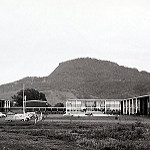

There are 2271 images of forests in the training set. Sample:


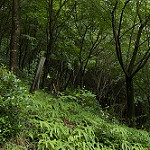

There are 2404 images of glaciers in the training set. Sample:


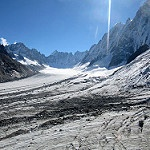

There are 2512 images of mountains in the training set. Sample:


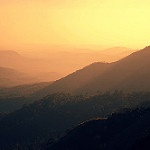

There are 2274 images of seas in the training set. Sample:


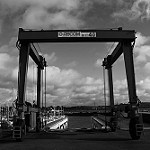

There are 2382 images of streets in the training set. Sample:


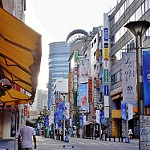

In [5]:
# Look at sample images of each class
print(f"There are {len(os.listdir(dir_train_buildings))} images of buildings in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_buildings, os.listdir(dir_train_buildings)[0])}"))
print(f"There are {len(os.listdir(dir_train_forest))} images of forests in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_forest, os.listdir(dir_train_forest)[0])}"))
print(f"There are {len(os.listdir(dir_train_glacier))} images of glaciers in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_glacier, os.listdir(dir_train_glacier)[0])}"))
print(f"There are {len(os.listdir(dir_train_mountain))} images of mountains in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_mountain, os.listdir(dir_train_mountain)[0])}"))
print(f"There are {len(os.listdir(dir_train_sea))} images of seas in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_sea, os.listdir(dir_train_sea)[0])}"))
print(f"There are {len(os.listdir(dir_train_street))} images of streets in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_street, os.listdir(dir_train_street)[0])}"))

It would be useful to understand the balance of classes in both training and test sets, and how the data has been split between training and testing. 

In [6]:
dirs_train = [dir_train_buildings,dir_train_forest,dir_train_glacier,dir_train_mountain,dir_train_sea,dir_train_street]
dirs_test = [dir_test_buildings,dir_test_forest,dir_test_glacier,dir_test_mountain,dir_test_sea,dir_test_street]
cols = ['buildings','forests','glaciers','mountains','seas','streets']

tot_train = sum([len(os.listdir(d)) for d in dirs_train])
tot_test = sum([len(os.listdir(d)) for d in dirs_test])
    
train_counts = [[len(os.listdir(d)),(len(os.listdir(d))/tot_train)*100] for d in dirs_train]
test_counts = [[len(os.listdir(d)),(len(os.listdir(d))/tot_test)*100] for d in dirs_test]

In [7]:
class_counts_train = pd.DataFrame(data=np.array(train_counts).T,columns=cols)
class_counts_train['Training data'] = ['Count','Proportion (%)']
class_counts_train.set_index('Training data',inplace=True)

class_counts_test = pd.DataFrame(data=np.array(test_counts).T,columns=cols)
class_counts_test['Test data'] = ['Count','Proportion (%)']
class_counts_test.set_index('Test data',inplace=True)

print(class_counts_train)
print('\n')
print(class_counts_test)
print('\n')
print(f"The training split is {100*tot_train/(tot_train+tot_test):.2f}% of the total dataset")

                buildings  forests  glaciers  mountains  seas  streets
Training data                                                         
Count               2,191    2,271     2,404      2,512 2,274    2,382
Proportion (%)         16       16        17         18    16       17


                buildings  forests  glaciers  mountains  seas  streets
Test data                                                             
Count                 437      474       553        525   510      501
Proportion (%)         15       16        18         18    17       17


The training split is 82.39% of the total dataset


**Simple subset of data**

Move some files into a separate directory to reduce problem to simple binary classification as a learning exercise.

In [5]:
dir_train_sub = os.path.join(data_dir,'sub_train')
dir_test_sub = os.path.join(data_dir, 'sub_test')

In [47]:
# create new folders (only run once)
os.makedirs(os.path.join(data_dir,'sub_train/forest'))
os.makedirs(os.path.join(data_dir,'sub_test/forest'))
os.makedirs(os.path.join(data_dir,'sub_train/sea'))
os.makedirs(os.path.join(data_dir,'sub_test/sea'))

# copy 500 files for each class for training, and 50 of each for validation
dir_train_forest
dir_train_sea

In [53]:
# copy 500 files for each class for training, and 50 of each for validation (forest)
for idx, file in enumerate(os.listdir(dir_train_forest)[:550]):
    if idx < 500:
        shutil.copy(os.path.join(dir_train_forest,file),os.path.join(data_dir,'sub_train/forest'))
    else:
        shutil.copy(os.path.join(dir_train_forest,file),os.path.join(data_dir,'sub_test/forest'))

In [54]:
# copy 500 files for each class for training, and 50 of each for validation (sea)
for idx, file in enumerate(os.listdir(dir_train_sea)[:550]):
    if idx < 500:
        shutil.copy(os.path.join(dir_train_sea,file),os.path.join(data_dir,'sub_train/sea'))
    else:
        shutil.copy(os.path.join(dir_train_sea,file),os.path.join(data_dir,'sub_test/sea'))

### Data cleaning

Excellent, we have balanced class sizes in the training and test sets. Now we should investigate if any data cleaning is required?
- Look for corrupt files (size smaller than 1 byte)
- Look for files without an extension *.jpg

In [8]:
# search in all directories for files less than 1 byte
tot_err = 0
for path in Path(data_dir).rglob('*.jpg'):
    if os.path.getsize(path) < 1:
        tot_err+=1
assert tot_err==0

In [9]:
# find number of files in the prediction set
tot_pred = 0
for base, dirs, files in os.walk(dir_pred):
    for Files in files:
        tot_pred += 1

# search in all directories for files with the .jpg extension and check this against total number of files
count_jpg=0
for path in Path(data_dir).rglob('*.jpg'):
    count_jpg+=1

assert count_jpg==tot_train+tot_test+tot_pred

### Model development, training and evaluation

Now, that we are confident we have a clean and well-balanced dataset that is organised into directories according to label, we can proceed to the model building stage. Given this is a large dataset and a complex problem that will require a significant time for the model to train, the following strategy will be undertaken:
 1. Initially reduce the problem to binary classification with only two of the classes
 2. Initially only use a subset of the data (1000 images) for training
 3. Start with a simple network architecture

In [1]:
# Start with a subset of data (e.g. 1000 images)
# Try with only one or two classes

# Start with a shallow neural network
# Then try with deeper / more complex neural nets

# Develop a function for model testing and evaluation
# Work up to a convolutional neural network
# Use tensorflow tooling for experiment tracking and tensorboard for visualising learning

**Simple Binary classification exercise**



**Prepare data for model training**

Keras's `ImageDataGenerator` can be used to feed your model with raw, rescaled or even augmented image data. Here, it will be used to:
- Normalize pixel values
- Standardize image resolutions
- Set a batch size for inference


The `flow_from_directory` method is used to read from the required directory

In [6]:
# point generator to training data (also standardize resolutions and set a batch size)
# class_mode "binary" refers to a 1D output of labels rather that "categorical" which is 2D OHE
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        dir_train_sub,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# point generator to test data (also standardize resolutions and set a batch size)
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        dir_test_sub,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
# sanity check to confirm class labels
print(f"labels in the train generator are: {train_generator.class_indices}")
print(f"labels in the validation generator are: {validation_generator.class_indices}")

# Get a batch of 32 images along with their true label and check shapes (32 images of shape 150x150)
data_imgs, labels = next(validation_generator)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

labels in the train generator are: {'forest': 0, 'sea': 1}
labels in the validation generator are: {'forest': 0, 'sea': 1}
data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


**Model building, training**

Define the model architecture, hyperparameters and compile accordingly.

For an interface to evaluate and debug different runs of the model's training, we can use the Tensorboard tool. Define a location for logs, and configure the log writer with your chosen hyperparams. Tensorboard callback should be pointed at log directory.

In [12]:
# define hyperparams and metrics
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_NUM_LAYERS = hp.HParam('num_hidden', hp.Discrete([1, 2, 3]))
#HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_ACTIVATION = hp.HParam('activation',hp.Discrete(['relu','sigmoid']))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.001, 0.01, 0.1]))
METRIC_ACCURACY = "accuracy"
                                                    
# configure tensorboard to track hyperparameter values / network architecture
logdir = os.path.join(os.curdir,"logs/hparam_tuning")

# create log writing config
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_ACTIVATION, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )                                                                                                                   

In [13]:
# define a function for training the model
def train_binary_clf(logdir, hparams):
    '''Returns validation accuracy after build, compilation and training of model with input hyperparams'''
    
    # build
    model_simple_binary = models.Sequential()
    model_simple_binary.add(layers.Flatten(input_shape=(150,150,3)))
    for i in range(hparams[HP_NUM_LAYERS]):
        model_simple_binary.add(layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION]))
    model_simple_binary.add(layers.Dense(1, activation="sigmoid"))
    
    # compile
    model_simple_binary.compile(
        loss="binary_crossentropy",
        optimizer=tf.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE]),
        metrics=["accuracy"])
    
    # train
    history = model_simple_binary.fit(
        x=train_generator,
        epochs=3,
        validation_data=validation_generator,
        callbacks=[keras.callbacks.TensorBoard(logdir)])
      
    return history.history['val_accuracy'][-1]


In [14]:
# define function to run model and store hyperparams/metrics
def run(run_logdir, hparams):
    '''Wrapper for train model function that logs hyperparams and scores to tensorboard'''
    with tf.summary.create_file_writer(run_logdir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_binary_clf(logdir, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [15]:
# loop through each set of hyperparams, running model and logging results
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for num_layers in HP_NUM_LAYERS.domain.values:
        for activation in (HP_ACTIVATION.domain.values):
            for learning_rate in HP_LEARNING_RATE.domain.values:

                hparams = {
                HP_NUM_UNITS: num_units,
                HP_NUM_LAYERS: num_layers,
                HP_ACTIVATION: activation,
                HP_LEARNING_RATE: learning_rate,
                }
                
                run_name = f"run-{session_num}"
                print(f'--- Starting trial: {run_name}')
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'num_hidden': 1, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/3
32/32 [==============================] - 2s 44ms/step - loss: 0.5897 - accuracy: 0.6760 - val_loss: 0.4905 - val_accuracy: 0.8200
Epoch 2/3
32/32 [==============================] - 1s 40ms/step - loss: 0.5053 - accuracy: 0.7400 - val_loss: 0.4224 - val_accuracy: 0.7800
Epoch 3/3
32/32 [==============================] - 1s 40ms/step - loss: 0.4293 - accuracy: 0.8030 - val_loss: 0.4099 - val_accuracy: 0.8600
--- Starting trial: run-1
{'num_units': 16, 'num_hidden': 1, 'activation': 'relu', 'learning_rate': 0.01}
Epoch 1/3
32/32 [==============================] - 2s 43ms/step - loss: 0.7853 - accuracy: 0.5070 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 2/3
32/32 [==============================] - 1s 39ms/step - loss: 0.6815 - accuracy: 0.5350 - val_loss: 0.6667 - val_accuracy: 0.8100
Epoch 3/3
32/32 [==============================] - 1s 34ms/step - loss: 0.6479 - accura

32/32 [==============================] - 1s 39ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/3
32/32 [==============================] - 1s 37ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.5000
--- Starting trial: run-16
{'num_units': 16, 'num_hidden': 3, 'activation': 'sigmoid', 'learning_rate': 0.01}
Epoch 1/3
32/32 [==============================] - 2s 42ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 2/3
32/32 [==============================] - 1s 39ms/step - loss: 0.6897 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 3/3
32/32 [==============================] - 1s 36ms/step - loss: 0.6888 - accuracy: 0.5100 - val_loss: 0.6883 - val_accuracy: 0.5000
--- Starting trial: run-17
{'num_units': 16, 'num_hidden': 3, 'activation': 'sigmoid', 'learning_rate': 0.1}
Epoch 1/3
32/32 [==============================] - 2s 43ms/step - loss: 0.6890 - accuracy: 

--- Starting trial: run-31
{'num_units': 32, 'num_hidden': 3, 'activation': 'relu', 'learning_rate': 0.01}
Epoch 1/3
32/32 [==============================] - 2s 44ms/step - loss: 0.6437 - accuracy: 0.5860 - val_loss: 0.5590 - val_accuracy: 0.7400
Epoch 2/3
32/32 [==============================] - 1s 39ms/step - loss: 0.5300 - accuracy: 0.7570 - val_loss: 0.4586 - val_accuracy: 0.8000
Epoch 3/3
32/32 [==============================] - 1s 36ms/step - loss: 0.4548 - accuracy: 0.7940 - val_loss: 0.4655 - val_accuracy: 0.8100
--- Starting trial: run-32
{'num_units': 32, 'num_hidden': 3, 'activation': 'relu', 'learning_rate': 0.1}
Epoch 1/3
32/32 [==============================] - 2s 46ms/step - loss: 20.7630 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
32/32 [==============================] - 1s 42ms/step - loss: 0.6935 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/3
32/32 [==============================] - 1s 43ms/step - loss: 0.6934 - accur

Pros of tensorboard:
 - really easy to set up to just view learning rates for debugging
 - keeps everything within the TF framework

Problems with using Tensorboard
 - can't work out how to link hyperparams back to run_ids to get all information on training
 - doesn't save model so you have to recreate it 
 - awkward and difficult to use makes it inflexible
 - limited documentation
 
Recommendations:
 - continue to use TB to view learning rates
 - switch over to MLFlow for hyperparameter logging and saving models


How to configure regularization parameter value and type?
 - add arguments in each layer for kernel_regularizer (weights), bias_regularizer (bias) and activity regularizer (activation)
 - OR add dropout regularization

How to configure learning rate for the network?
 - include it as an argument for the optimizer 

Run the following at the terminal (you must be in the ./notebooks directory) to spin up tensorboard.
```
tensorboard --logdir=./logs/hparam_tuning --port=6006
```
Navigate to http://localhost:6006/ to view tensorboard.

**Multi-class classification**

In [33]:
# define a simple architecture for multiclass classification
model_simple_multi = models.Sequential([
    layers.Flatten(input_shape=(150,150,3)),
    layers.Dense(100, activation="relu"),
    layers.Dense(6, activation="softmax")
])

model_simple_multi.compile(
    loss="categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"])

In [12]:
"""
# define the model architecture (a simple CNN)
# input_shape of (150,150,3) represents a 150x150 RGB image 
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
  ])

# define model architecture (very simple Keras)
# input_shape of (150,150,3) represents a 150x150 RGB image
# we use a final layer with  6 neurons (one of each class) and function softmax (as classes are exclusive)
'''
model = models.Sequential([
    layers.Flatten(input_shape=(150,150,3)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(6, activation="softmax")
])
'''

# Compile the model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer="sgd",
  metrics=["accuracy"]
)

print(model.summary())
""";

In [35]:
train_ds = image_dataset_from_directory(
        directory=dir_train_sub,
        labels="inferred",
        label_mode="categorical",
        image_size=(150,150),
        color_mode="rgb",
        batch_size=32,
        seed=0,
        validation_split=0.8,
        subset="training"
)

Found 14034 files belonging to 6 classes.
Using 2807 files for training.


In [39]:
history = model_simple_multi.fit(
        train_ds,
        epochs=10)

Epoch 1/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 2/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 3/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 4/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 5/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 6/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 7/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 8/10
88/88 [==============================] - 3s 29ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 9/10
88/88 [==============================] - 3s 28ms/step - loss: 1.7887 - accuracy: 0.1863
Epoch 10/10
88/88 [==============================] - 3s 29ms/step - loss: 1.7887 - accuracy: 0.1863


Use the below code to make use of all available training and validation data.

In [16]:
# normalize pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# point generator to training data (also standardize resolutions and set a batch size)
# class_mode "binary" refers to a 1D output of labels rather that "categorical" which is 2D OHE
train_generator = train_datagen.flow_from_directory(
        dir_train,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# point generator to test data (also standardize resolutions and set a batch size)
validation_generator = test_datagen.flow_from_directory(
        dir_test,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [17]:
# sanity check to confirm class labels
print(f"labels in the train generator are: {train_generator.class_indices}")
print(f"labels in the validation generator are: {validation_generator.class_indices}")

labels in the train generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
labels in the validation generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [18]:
# Get a batch of 32 images along with their true label
data_imgs, labels = next(validation_generator)

# Check shapes (32 images of shape 150x150)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


**Training the model**

In [22]:
# train the model using the training and validation generators
history = model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=30,
     validation_steps=80,
     validation_data=validation_generator)

Epoch 1/30
100/100 [==============================] - 49s 487ms/step - loss: 1.6372 - accuracy: 0.3500 - val_loss: 1.4749 - val_accuracy: 0.4051
Epoch 2/30
 75/100 [=====================>........] - ETA: 10s - loss: 1.3741 - accuracy: 0.4650

KeyboardInterrupt: 

**Model evaluation**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


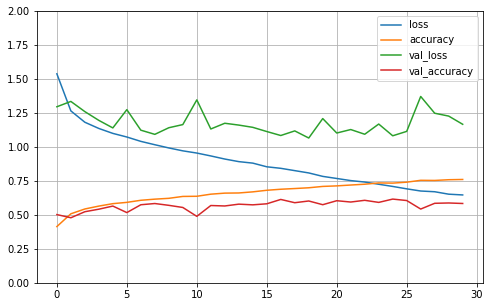

In [16]:
# the history attribute is a dictionary providing scores for each epoch 
print(history.history.keys())

# you can plot these values, which includes accuracy on the training set and accuracy on the validation set
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

**Save the model**

In [ ]:
# save the model as a h5 file or pb
model.save("my_keras_model.h5")